## *Pipeline* format

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # sklearn中的 随机森岭回归 梯度提升回归
from sklearn.linear_model import PoissonRegressor, GammaRegressor

from sklearn.model_selection import train_test_split
# https://xgboost.readthedocs.io/en/stable/tutorials/model.html
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor 
from sklearn.linear_model import RidgeCV, LassoCV 
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import time

plt.rcParams['font.sans-serif']=['Microsoft YaHei'] 
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams['font.family'] = ['Microsoft YaHei']

import warnings
warnings.filterwarnings("ignore") 

In [2]:
import numpy as np
from sklearn.utils import shuffle
import pandas as pd
from sklearn import set_config

set_config(display="diagram")

In [3]:
idata=pd.read_csv('all_features.csv', index_col='时间') # loading data
# shuffle
#idata=idata.sample(frac=1, axis=0,random_state=42, replace=False)

In [4]:
X = idata.drop('O₃-臭氧(μg/m³)', axis=1)
y = idata['O₃-臭氧(μg/m³)']

In [5]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# class FeatureSelector(BaseEstimator, TransformerMixin):
#     def __init__(self):
#        super().__init__()
#     def fit(self,X,y=None):
#        return self
#     def transform(self,X,y=None):
#        return X.drop('OZIPR', axis=1)

# class OZIPRinput(BaseEstimator, TransformerMixin):
#     def __init__(self):
#        super().__init__()
#     def fit(self,X,y=None):
#        return self
#     def transform(self,X,y=None):
#        return X.OZIPR.values

In [9]:
Data_processor = make_pipeline(StandardScaler())

In [10]:
rf_pipeline = make_pipeline(Data_processor, RandomForestRegressor(random_state=0, n_estimators=100, max_depth=20, oob_score=True), )
rf_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=20, oob_score=True,
                                       random_state=0))])

In [11]:
gbdt_pipeline = make_pipeline(Data_processor, GradientBoostingRegressor(random_state=0, n_estimators=100, learning_rate=0.1, max_depth=8))
gbdt_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=8, random_state=0))])

In [14]:
# MLP
MLP_pipeline = make_pipeline(Data_processor, MLPRegressor(random_state=20))
MLP_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('mlpregressor', MLPRegressor(random_state=20))])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3) # 数据集分割 默认test占比0.25
rf_pipeline.fit(X_train, y_train)
gbdt_pipeline.fit(X_train, y_train)
MLP_pipeline.fit(X_train, y_train)
print('rf',rf_pipeline.score(X_test, y_test))
print('gb',gbdt_pipeline.score(X_test, y_test))
print('MLP',MLP_pipeline.score(X_test, y_test))

rf 0.8568272869770663
gb 0.8653817064605327
MLP 0.8269048164593857


In [16]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

estimators = [
    ("Random Forest", rf_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
    ("Multi-layer Perceptron", MLP_pipeline)
    ]

stacking_regressor = StackingRegressor(estimators=estimators,final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('standardscaler',
                                                                 StandardScaler())])),
                                               ('randomforestregressor',
                                                RandomForestRegressor(max_depth=20,
                                                                      oob_score=True,
                                                                      random_state=0))])),
                              ('Gradient Boosting',
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('standardscaler',
                                                                 StandardScaler())])),
                                               ('gradientboostingregressor',
                                                GradientBoostingRegressor(max_depth=8,
                                                                          random_state=0))])),
                              ('Multi-layer Perceptron',
                               Pipeline(steps=[('pipeline',
                                                Pipeline(steps=[('standardscaler',
                                                                 StandardScaler())])),
                                               ('mlpregressor',
                                                MLPRegressor(random_state=20))]))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1) # 数据集分割 默认test占比0.25
stacking_regressor.fit(X_train,y_train)
stacking_regressor.score(X_test,y_test)

0.8572053423309061

## Plot

In [18]:
idata_SC=pd.read_csv('all_features_high.csv', index_col='时间')
X_SC = idata_SC.drop('O₃-臭氧(μg/m³)', axis=1)
y_SC = idata_SC['O₃-臭氧(μg/m³)']

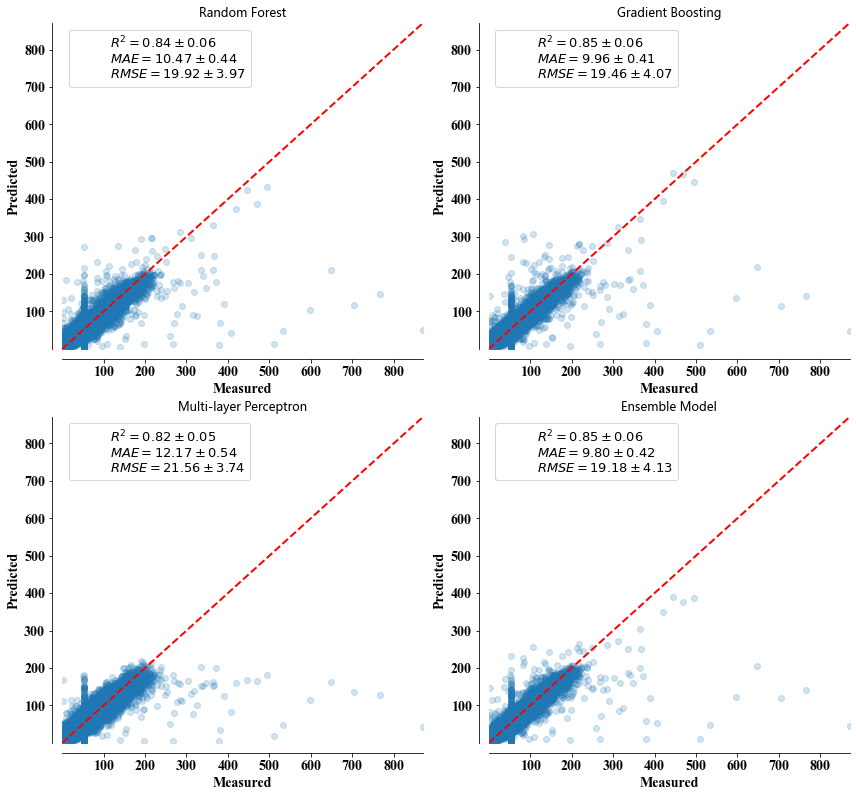

In [19]:
import time
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.model_selection import cross_validate, cross_val_predict


def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot(
        [y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "--r", linewidth=2
    )
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel("Measured", {"fontproperties":"Times New Roman", "fontsize":14, "fontweight":'bold'})
    ax.set_ylabel("Predicted", {"fontproperties":"Times New Roman", "fontsize":14, "fontweight":'bold'})
    extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0)
   
  
    ax.legend([extra], [scores], loc="upper left",  prop=font_manager.FontProperties(size=13, family='Times New Roman', weight='bold'))
   # title = title + "\n Evaluation in {:.2f} seconds".format(elapsed_time)
    ax.set_title(title)    
    for xtick in ax.xaxis.get_major_ticks():
        xtick.label.set_fontproperties('Times New Roman')
        xtick.label.set_fontsize(14)
        xtick.label.set_fontweight('bold')        
    for ytick in ax.yaxis.get_major_ticks():
        ytick.label.set_fontproperties('Times New Roman')
        ytick.label.set_fontsize(14)
        ytick.label.set_fontweight('bold')
    




fig, axs = plt.subplots(2,2, figsize=(12, 12))
axs = np.ravel(axs)

for ax, (name, est) in zip(

   axs, estimators + [("Ensemble Model", stacking_regressor)]
 ):
   
    start_time = time.time()
    score = cross_validate(
        est, X, y, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"], n_jobs=-1, verbose=0, cv=10
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)

   
    plot_regression_results(
        ax,
        y,
        y_pred,
        name,
      (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$MAE={:.2f} \pm {:.2f}$"+ "\n" + r"$RMSE={:.2f} \pm {:.2f}$").format(
            np.mean(score["test_r2"]),
            np.std(score["test_r2"]),
            -np.mean(score["test_neg_mean_absolute_error"]),
            np.std(score["test_neg_mean_absolute_error"]),
            -np.mean(score["test_neg_root_mean_squared_error"]),
            np.std(score["test_neg_root_mean_squared_error"]),
        ),
        elapsed_time,
    )


plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()